In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Считываем данные
import pandas as pd
features = pd.read_csv('/content/drive/My Drive/FinalProjectDota/features.csv', index_col='match_id')
test = pd.read_csv('/content/drive/My Drive/FinalProjectDota/features_test.csv', index_col='match_id')
features

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,7,2,616,535,0,0,2,10,1,3,879,1798,22,1,1,9,21,4,1835,1350,11,1,1,9,71,3,604,567,1,0,...,972,847,1,1,1,11,28,3,1583,1634,10,2,0,6,114.0,0.0,2.0,8.0,245.0,-86.0,211.0,5,2,1,0,-29.0,180.0,-76.0,180.0,3,4,3,0,-24.0,2032,0,1792,1975,48,63
114403,1450277704,0,43,4,1793,1416,17,0,1,5,26,3,764,800,0,1,0,9,4,3,1130,1585,20,1,1,14,29,4,1546,1166,8,1,0,6,110,3,892,541,1,0,...,1260,1008,4,1,1,12,98,5,1791,1186,3,1,0,8,174.0,1.0,9.0,4.0,139.0,-85.0,202.0,5,3,2,0,-5.0,NaN,-82.0,NaN,4,3,2,0,-17.0,1734,1,2038,6,63,3
114404,1450291848,1,98,4,1399,540,1,0,0,5,11,4,1448,1371,17,0,1,13,112,3,658,646,2,0,0,10,81,4,1710,1833,24,1,0,10,50,2,364,674,1,0,...,1778,1614,27,0,0,8,31,3,841,499,1,0,0,10,108.0,0.0,3.0,5.0,43.0,-83.0,181.0,2,4,4,2,-32.0,249.0,-70.0,NaN,1,1,3,1,-15.0,2906,0,1796,1846,51,63


# 1. Градиентный бустинг 'В лоб'

In [ ]:
# Посмотрим на названия колонок
print(features.columns.values)

['start_time' 'lobby_type' 'r1_hero' 'r1_level' 'r1_xp' 'r1_gold' 'r1_lh'
 'r1_kills' 'r1_deaths' 'r1_items' 'r2_hero' 'r2_level' 'r2_xp' 'r2_gold'
 'r2_lh' 'r2_kills' 'r2_deaths' 'r2_items' 'r3_hero' 'r3_level' 'r3_xp'
 'r3_gold' 'r3_lh' 'r3_kills' 'r3_deaths' 'r3_items' 'r4_hero' 'r4_level'
 'r4_xp' 'r4_gold' 'r4_lh' 'r4_kills' 'r4_deaths' 'r4_items' 'r5_hero'
 'r5_level' 'r5_xp' 'r5_gold' 'r5_lh' 'r5_kills' 'r5_deaths' 'r5_items'
 'd1_hero' 'd1_level' 'd1_xp' 'd1_gold' 'd1_lh' 'd1_kills' 'd1_deaths'
 'd1_items' 'd2_hero' 'd2_level' 'd2_xp' 'd2_gold' 'd2_lh' 'd2_kills'
 'd2_deaths' 'd2_items' 'd3_hero' 'd3_level' 'd3_xp' 'd3_gold' 'd3_lh'
 'd3_kills' 'd3_deaths' 'd3_items' 'd4_hero' 'd4_level' 'd4_xp' 'd4_gold'
 'd4_lh' 'd4_kills' 'd4_deaths' 'd4_items' 'd5_hero' 'd5_level' 'd5_xp'
 'd5_gold' 'd5_lh' 'd5_kills' 'd5_deaths' 'd5_items' 'first_blood_time'
 'first_blood_team' 'first_blood_player1' 'first_blood_player2'
 'radiant_bottle_time' 'radiant_courier_time'
 'radiant_flying_courie

In [ ]:
#Удаляем признаки, связанные с итогами матча
y = features['radiant_win']
features.drop(columns=['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], inplace=True)

In [ ]:
features.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,97230.000000,97230.000000,97230.000000,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,3.364661,1189.223676,1107.863993,10.471747,0.348709,0.363550,8.275584,52.710491,3.353924,1182.879965,1099.643742,10.333004,0.342723,0.357338,8.273527,52.648092,3.308896,1159.088481,1082.090240,9.981909,0.337746,0.357307,8.275049,52.625630,3.304237,1158.586167,1082.057061,9.995351,0.337262,...,10.386918,0.353533,0.347732,8.305420,52.922421,3.337725,1171.952155,1088.711653,10.035349,0.354952,0.341860,8.319665,53.059694,3.345274,1177.395351,1089.558850,10.053739,0.356063,0.342538,8.323048,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,2.994775,3.312527,2.431719,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,1.097536,555.363510,458.001007,8.972073,0.654060,0.624236,2.433864,32.560923,1.092126,554.899600,454.727127,8.950871,0.647774,0.618071,2.440139,32.670519,1.092502,550.937530,450.353291,8.917997,0.642908,0.616181,2.427832,32.608231,1.095842,553.020429,453.165214,8.948413,0.643538,...,8.901528,0.656819,0.608922,2.434323,32.460902,1.085221,547.308063,448.416794,8.872503,0.658713,0.602357,2.427417,32.535112,1.091848,550.887551,449.877513,8.882013,0.659190,0.605956,2.432850,82.625879,0.499527,2.886984,2.870915,61.427907,15.814209,34.604997,1.933283,1.154414,0.811435,0.725331,39.508650,62.442018,15.261950,34.137158,1.907288,1.155609,0.813459,0.710122,40.701397
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,

In [ ]:
print('Формат обучающей выборки: ', features.shape)

Формат обучающей выборки:  (97230, 102)


In [ ]:
# Посмотрим на формат данных
features.info(max_cols=108)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Data columns (total 102 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   start_time                   97230 non-null  int64  
 1   lobby_type                   97230 non-null  int64  
 2   r1_hero                      97230 non-null  int64  
 3   r1_level                     97230 non-null  int64  
 4   r1_xp                        97230 non-null  int64  
 5   r1_gold                      97230 non-null  int64  
 6   r1_lh                        97230 non-null  int64  
 7   r1_kills                     97230 non-null  int64  
 8   r1_deaths                    97230 non-null  int64  
 9   r1_items                     97230 non-null  int64  
 10  r2_hero                      97230 non-null  int64  
 11  r2_level                     97230 non-null  int64  
 12  r2_xp                        97230 non-null  int64  
 13  r2_gold       

In [ ]:
features.dtypes.value_counts()

int64      90
float64    12
dtype: int64

Часть данных неполная, все данные числовые. Среди них есть категориальные, но мы их пока трогать не будем

## Распределение целевой переменно

In [ ]:
y.value_counts()

1    50414
0    46816
Name: radiant_win, dtype: int64

<function matplotlib.pyplot.show>

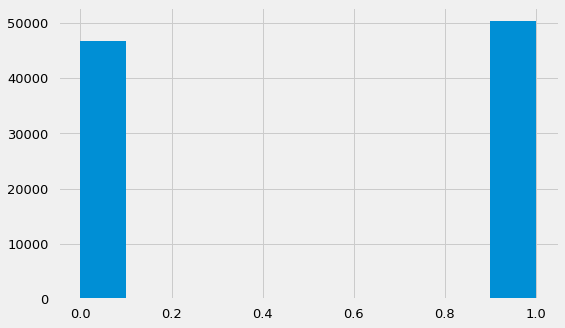

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8,5]

plt.hist(y)
plt.show

## Исследование пропущенных значений

In [ ]:
def nan_info(data):
  '''
  Печатает признаки, в которых есть пропущенные значения,
  и их количество
  Возвращает DataFrame с добавлением процентов пропущенного
  значения от общего для каждого признака
  '''
  columns = []
  values = []
  for i in data.columns.values:
    if data[i].count() < len(data):
      print(f'В колонке {i} - {len(data) - data[i].count()} пропущенных значений')
      columns.append(i)
      values.append(len(features) - features[i].count())
  missing_values = pd.DataFrame(index=columns, columns=['Missing Values', '% of Total Values'])
  for i in range(len(values)):
    missing_values.iloc[i,0] = values[i]
    missing_values.iloc[i,1] = round(values[i] / len(data) * 100, 1)
  return missing_values
  

In [ ]:
df_missing = nan_info(features)

В колонке first_blood_time - 19553 пропущенных значений
В колонке first_blood_team - 19553 пропущенных значений
В колонке first_blood_player1 - 19553 пропущенных значений
В колонке first_blood_player2 - 43987 пропущенных значений
В колонке radiant_bottle_time - 15691 пропущенных значений
В колонке radiant_courier_time - 692 пропущенных значений
В колонке radiant_flying_courier_time - 27479 пропущенных значений
В колонке radiant_first_ward_time - 1836 пропущенных значений
В колонке dire_bottle_time - 16143 пропущенных значений
В колонке dire_courier_time - 676 пропущенных значений
В колонке dire_flying_courier_time - 26098 пропущенных значений
В колонке dire_first_ward_time - 1826 пропущенных значений


In [ ]:
df_missing

,Missing Values,% of Total Values
first_blood_time,19553,20.1
first_blood_team,19553,20.1
first_blood_player1,19553,20.1
first_blood_player2,43987,45.2
radiant_bottle_time,15691,16.1
radiant_courier_time,692,0.7
radiant_flying_courier_time,27479,28.3
radiant_first_ward_time,1836,1.9
dire_bottle_time,16143,16.6
dire_courier_time,676,0.7


## Представим в графичиском формате

In [ ]:
def print_nan_info(data_train, data_test):
  '''
  Представляет в графическом формате долю
  пропущенных значений в данных
  '''
  import seaborn as sns
  plt.style.use('seaborn-talk')

  fig = plt.figure(figsize=(25,8))
  miss_train = pd.DataFrame(data_train.isnull().sum() / data_train.shape[0] * 100).reset_index()
  miss_test = pd.DataFrame(data_test.isnull().sum() / data_test.shape[0] * 100).reset_index()
  miss_train['type'] = 'Тренировочная'
  miss_test['type'] = 'Тестовая'
  missing = pd.concat([miss_train, miss_test], axis=0)
  ax = sns.pointplot(x='index', y=0, data=missing, hue='type')
  plt.xticks(rotation=90, fontsize=8)
  plt.title('Доля пропущенных значений в данных')
  plt.xlabel('Столбцы')
  plt.ylabel('Доля в %')

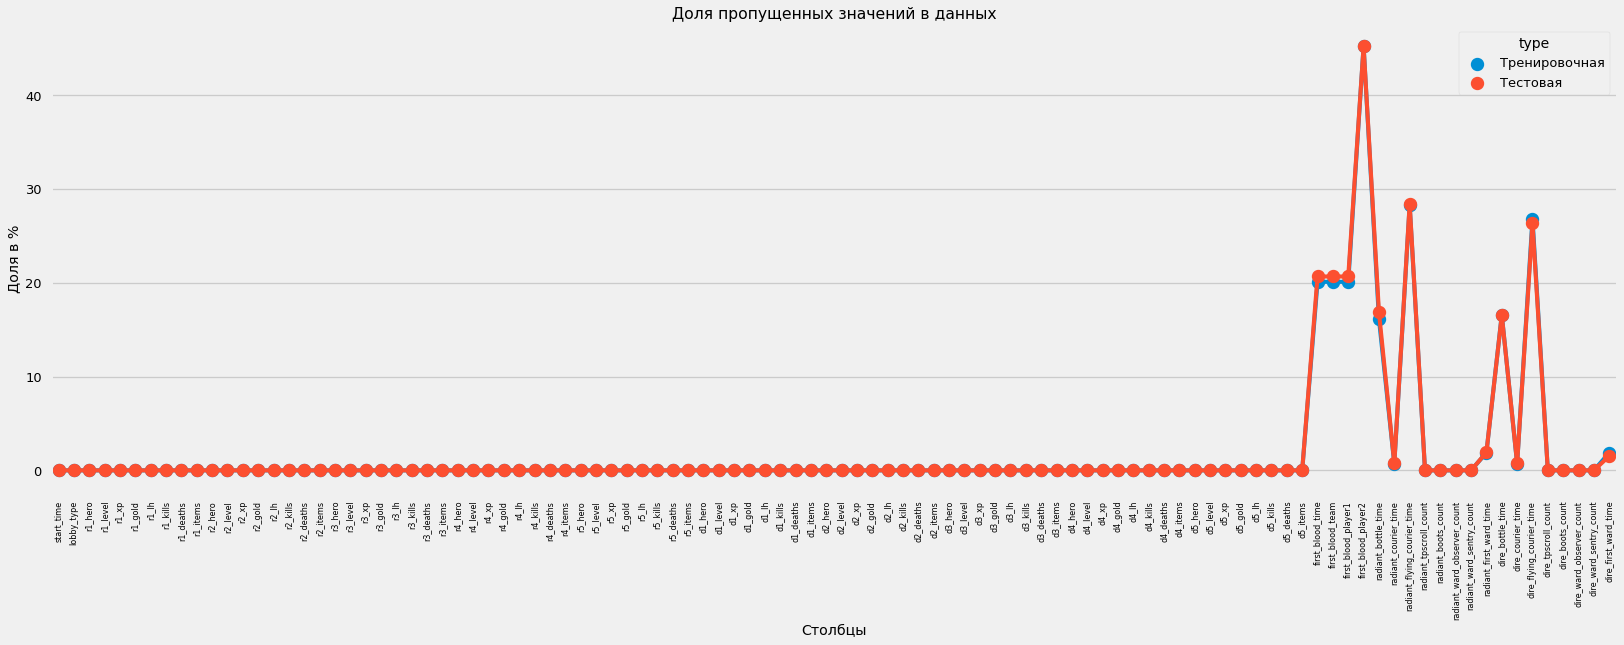

In [ ]:
print_nan_info(features, test)

1) Первые 4 признака относятся к событию "Первая кровь". Большое их количество вполне логично. Это означает что в первые 5 минут игры не происходило серьезных столкновений. 

2) Далее идут признаки, характеризующие время приобретения какого либо предмета. Как человек не игравший в эту игру, могу лишь предположить, что эти приобретения характеризуют успешность начала партии для той или иной команды. Пропуски в данных означают что команда не успела приобрести этот предмет = преимущество за первые 5 минут игры, что может негативно сказаться на результате партии в целом.

In [ ]:
# Проверим размеры выборок
print('Формат обучающей выборки: ', features.shape)
print('Формат тестовой выборки: ', test.shape)

Формат обучающей выборки:  (97230, 102)
Формат тестовой выборки:  (17177, 102)


## Корреляция в данных

Хороший метод понять данные — рассчитать коэффициенты корреляции Пирсона для данных относительно целевого признака. Это не лучший метод показать релевантность признаков, но он прост и позволяет составить представление о данных. Интерпретировать коэффициенты можно следующим образом:

    00-.19 “очень слабая”
    20-.39 “слабая”
    40-.59 “средняя”
    60-.79 “сильная”
    80-1.0 “очень сильная”


In [ ]:
def corr_pirson(data, target):
  '''
  Находит корреляцию пирсона в данных для
  целевой переменной и выводит 15 наибольших 
  положительных и отрицательных значений

  data : DataFrame
      Выборка в формате Pandas.DataFrame

  target : str
      Название целевой переменной 
  '''
  
  correlations = data.corr()[target].sort_values()

  print('Наивысшая позитивная корреляция: \n', correlations.tail(15))
  print('Наивысшая негативная корреляция: \n', correlations.head(15))

In [ ]:
features_and_target = pd.concat([features, y], axis=1)
features_and_target.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,1
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,0
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,0
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,0


In [ ]:
corr_pirson(features_and_target, target='radiant_win')

Наивысшая позитивная корреляция: 
 d3_deaths              0.079623
r1_kills               0.080822
d4_deaths              0.081313
d2_deaths              0.081631
d5_deaths              0.084491
d1_deaths              0.085073
r3_gold                0.087920
dire_tpscroll_count    0.088593
r4_gold                0.093500
r1_gold                0.093568
r5_gold                0.095127
r2_gold                0.099026
first_blood_player2    0.114789
radiant_boots_count    0.119114
radiant_win            1.000000
Name: radiant_win, dtype: float64
Наивысшая негативная корреляция: 
 first_blood_team         -0.150459
first_blood_player1      -0.131664
dire_boots_count         -0.111190
d2_gold                  -0.100069
d5_gold                  -0.096441
d1_gold                  -0.095780
d4_gold                  -0.091579
d3_gold                  -0.088824
r4_deaths                -0.088268
r5_deaths                -0.085459
r2_deaths                -0.083130
radiant_tpscroll_count   -0.082

Таким образом все данные слабо коррелируют с таргетом. Однако выделяются данные из категории 'Первая кровь', а так же число предметов 'boots'. Немаловажным является количество и золота, полученное игроками. Наибольшее влияние оказывают 2 и 5 игроки.


Посмотрим на распределения ядерной плотности для этих признаков

In [ ]:
import seaborn as sns

In [ ]:
def print_KDE(data, target, features=[]):
  '''
  Отрисовывает графики распределения ядерной плотности для заданных признаков
  data : pd.DataFrame
    Данные
  target : str
    Целевая переменная
  features : list
    Список признаков
  '''
  for i in range(len(features)):

    plt.figure()
    sns.kdeplot(data.loc[data[target] == 0, features[i]], label='target==0')
    sns.kdeplot(data.loc[data[target] == 1, features[i]], label='target==1')

    plt.xlabel(f'{features[i]}')
    plt.ylabel('Density')
    plt.title(f'Distribution of {features[i]}')

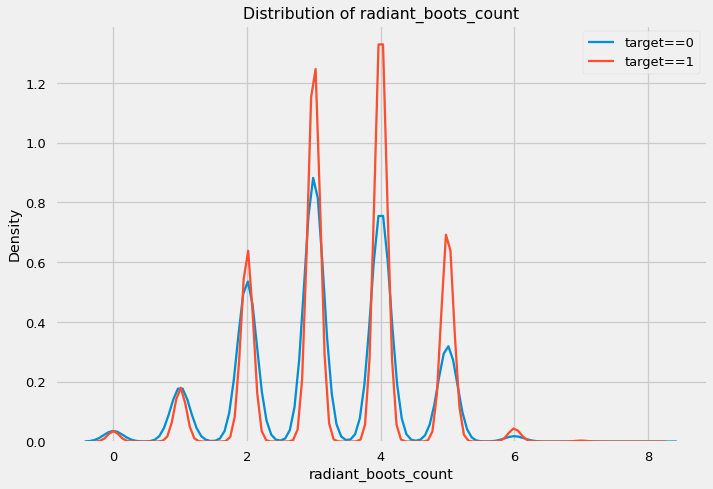

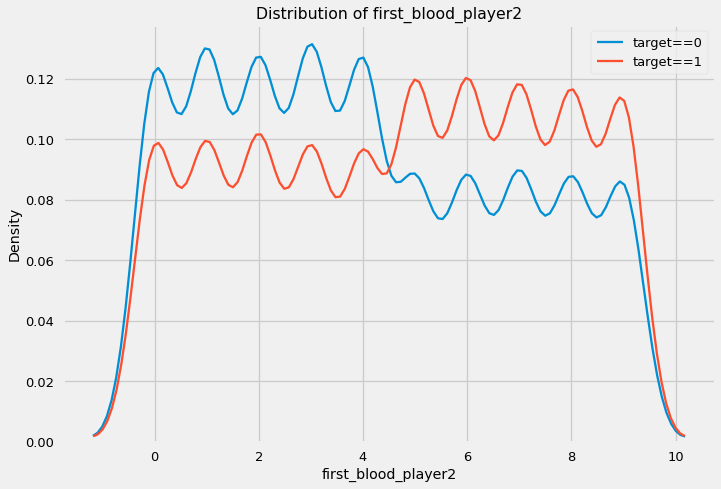

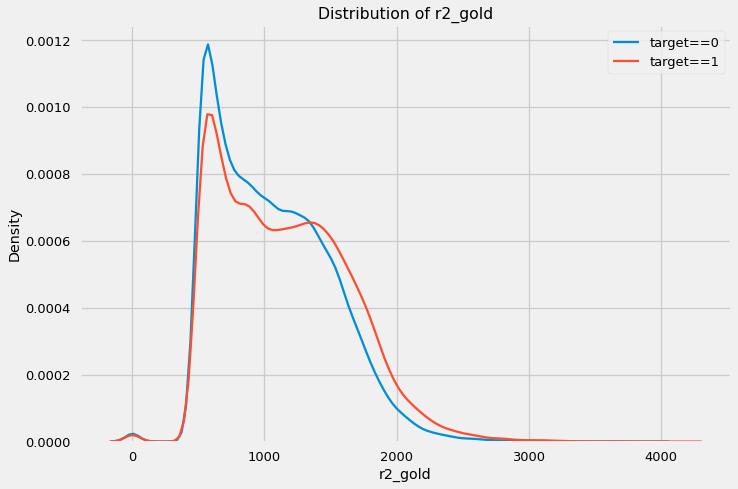

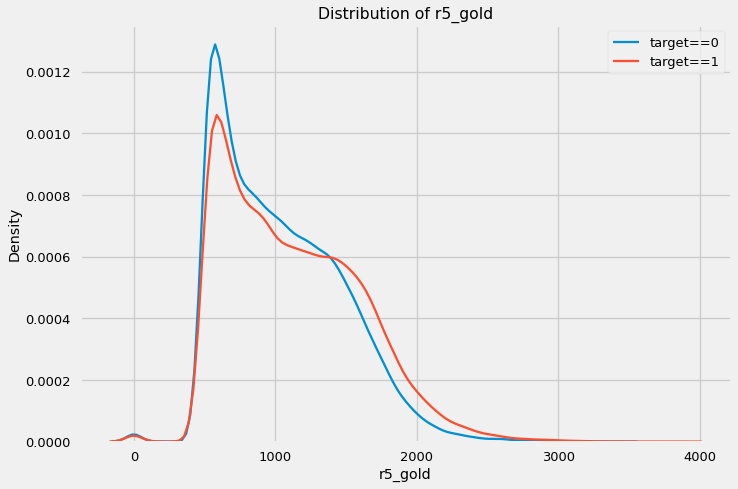

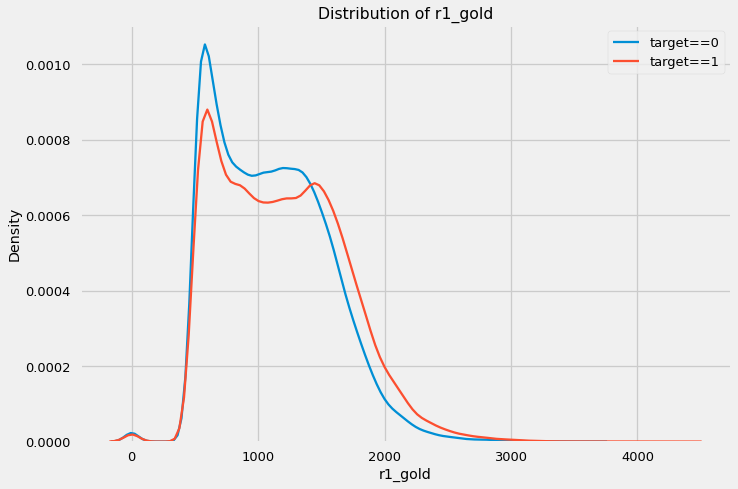

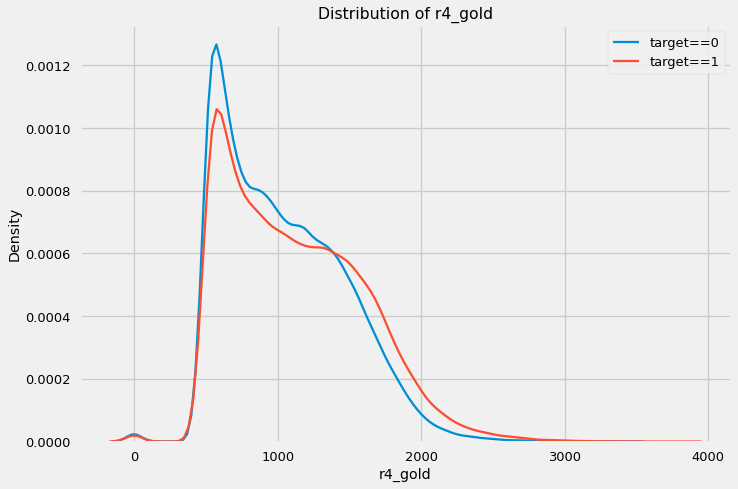

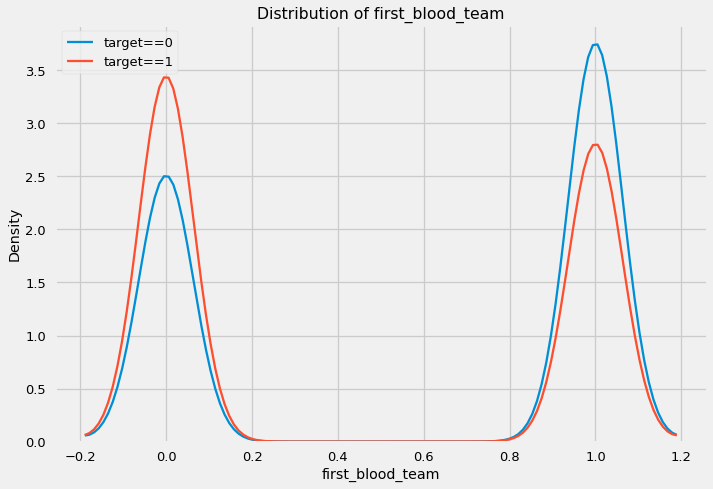

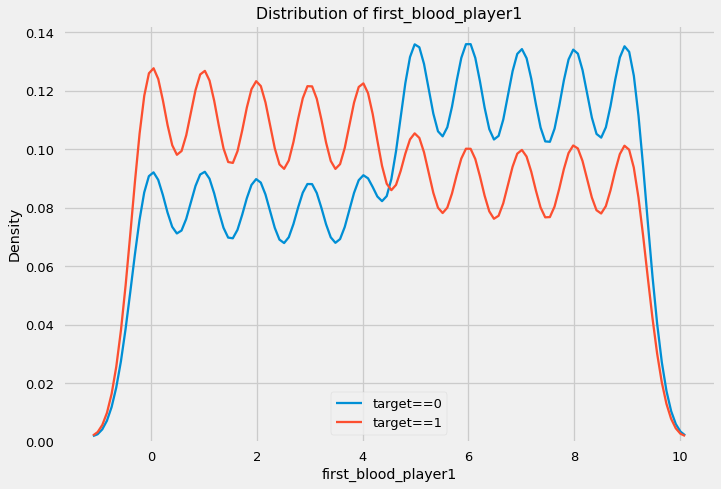

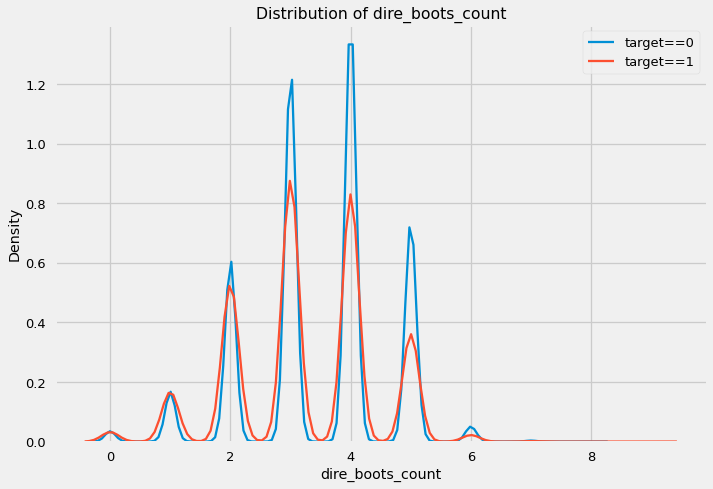

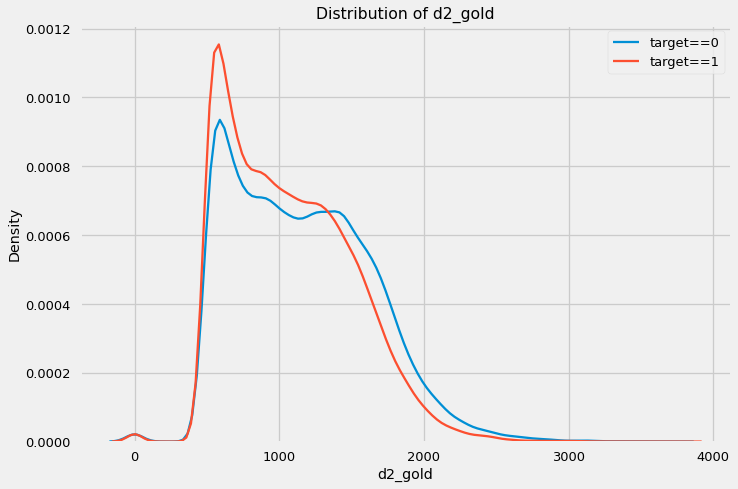

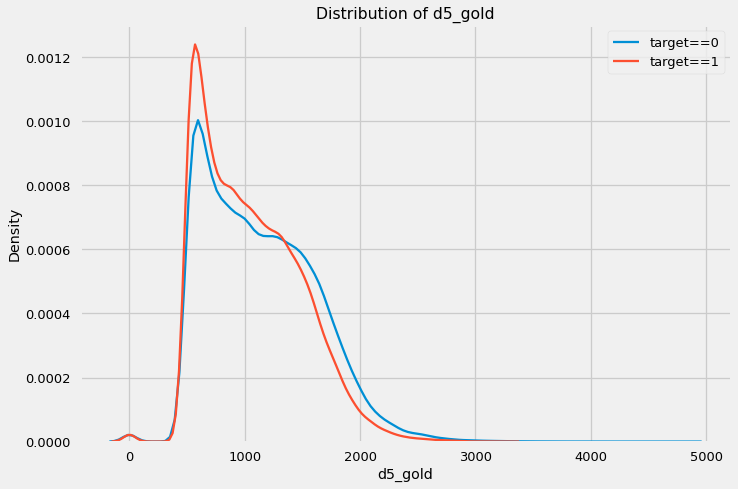

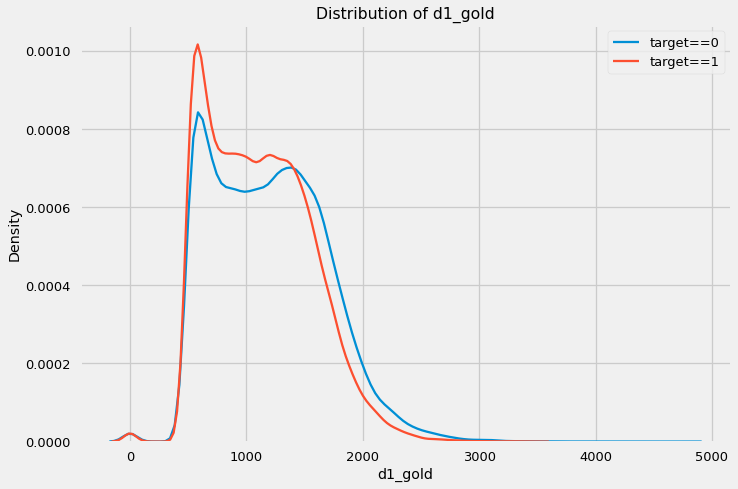

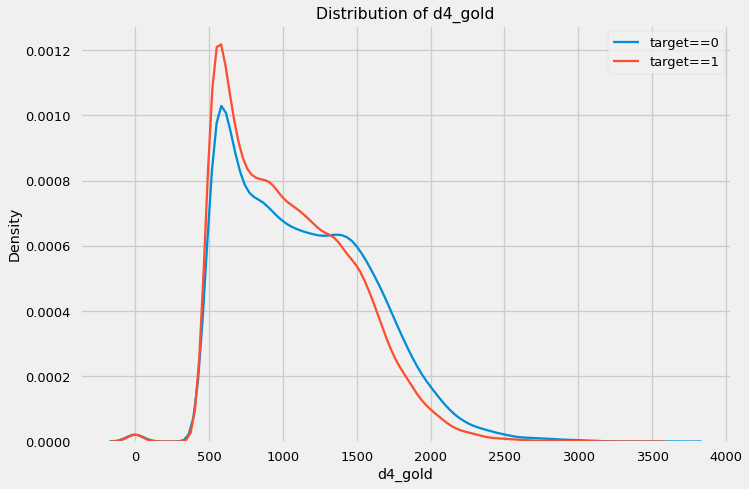

In [ ]:
features_for_KDE = ['radiant_boots_count', 'first_blood_player2', 'r2_gold', 'r5_gold', 'r1_gold',  'r4_gold', 'first_blood_team', 'first_blood_player1', 'dire_boots_count', 'd2_gold', 'd5_gold', 'd1_gold', 'd4_gold']
print_KDE(features_and_target, target='radiant_win', features=features_for_KDE)

Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [ ]:
df_missing

,Missing Values,% of Total Values
first_blood_time,19553,20.1
first_blood_team,19553,20.1
first_blood_player1,19553,20.1
first_blood_player2,43987,45.2
radiant_bottle_time,15691,16.1
radiant_courier_time,692,0.7
radiant_flying_courier_time,27479,28.3
radiant_first_ward_time,1836,1.9
dire_bottle_time,16143,16.6
dire_courier_time,676,0.7


In [ ]:
# Заменим пропущенные значения средним значением по выборке
from sklearn.impute import SimpleImputer
import numpy as np 

X_mean = features.copy()
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_mean)

X_mean = imputer.transform(X_mean)
test_mean = imputer.transform(test)
# Проверим форматы выборок
print('Формат обучающей выборки: ', X_mean.shape)
print('Формат тестовой выборки: ', test_mean.shape)

Формат обучающей выборки:  (97230, 102)
Формат тестовой выборки:  (17177, 102)


## Градиентный бустинг обучение

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score
import time
import datetime

In [ ]:
# Обучим классификатор с различным значением параметра n_estimators
kf = KFold(n_splits=5, random_state=1, shuffle=True)
kf.get_n_splits(X_mean)
parametrs = {'n_estimators': np.arange(10, 110, 10)}
model = GradientBoostingClassifier(random_state=241)
gs = GridSearchCV(model, parametrs, scoring='roc_auc', cv=kf)

gs.fit(X_mean,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fr...n_leaf=0.0,
                                                  n_estimators=100,
                         

In [ ]:
gs.best_params_

{'n_estimators': 100}

In [ ]:
# Посмотрим результаты
df = pd.DataFrame(gs.cv_results_).drop('params', axis=1) 
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.433565,0.037582,0.021128,0.000231,10,0.658632,0.667305,0.661959,0.664223,0.663017,0.663027,0.002835,10
1,24.648890,0.154240,0.027166,0.003199,20,0.679805,0.683622,0.681148,0.679627,0.683646,0.681570,0.001766,9
2,36.871532,0.123372,0.031923,0.002430,30,0.688074,0.691334,0.689119,0.686767,0.690400,0.689139,0.001623,8
3,49.099073,0.086921,0.036304,0.001094,40,0.692636,0.696046,0.694118,0.690474,0.694760,0.693607,0.001913,7
4,61.053477,0.150821,0.041571,0.001600,50,0.695927,0.699883,0.697230,0.693764,0.697963,0.696953,0.002045,6
5,73.261788,0.168053,0.045812,0.000295,60,0.698449,0.702529,0.699916,0.696489,0.700964,0.699669,0.002075,5
6,85.749899,0.387911,0.051241,0.001744,70,0.700741,0.705017,0.702099,0.698561,0.702831,0.701850,0.002149,4
7,97.859764,0.944048,0.055011,0.000219,80,0.701978,0.706199,0.704410,0.700430,0.703930,0.703389,0.001999,3
8,109.896546,1.075482,0.061191,0.000568,90,0.703065,0.707647,0.705629,0.701682,0.705269,0.704658,0.002081,2
9,122.278765,1.040595,0.065929,0.000961,100,0.703769,0.709017,0.707196,0.703225,0.706300,0.705901,0.002157,1


<Figure size 432x288 with 0 Axes>

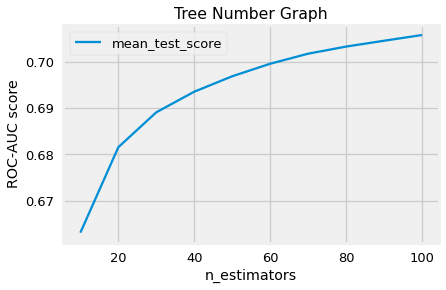

In [ ]:
plt.figure()
df.plot('param_n_estimators', 'mean_test_score', )
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC score')
plt.title('Tree Number Graph')
plt.show()

In [ ]:
# Обучим Градиентный бустинг с параметром n_estimators=30

start_time = datetime.datetime.now()

gbc = GradientBoostingClassifier(n_estimators=30, random_state=241)
scores = cross_val_score(gbc, X_mean, y, cv=5, scoring='roc_auc')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Time elapsed:', datetime.datetime.now() - start_time)

[0.69136337 0.68302757 0.66483649 0.67589332 0.53767958]
Accuracy: 0.65 (+/- 0.11)
Time elapsed: 0:03:02.548691


In [ ]:
# Посмотрим на качество при замене пропущенных значений на очень большие
X_big = features.copy()
X_big.fillna(100000, inplace=True)

start_time = datetime.datetime.now()

gbc = GradientBoostingClassifier(n_estimators=30, random_state=241)
scores = cross_val_score(gbc, X_big, y, cv=5, scoring='roc_auc')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Time elapsed:', datetime.datetime.now() - start_time)

[0.65770875 0.68302757 0.66820244 0.67507604 0.57994256]
Accuracy: 0.65 (+/- 0.07)
Time elapsed: 0:02:35.331781


In [ ]:
# Посмотрим на качество при замене пропущенных значений на ноль
X_null = features.copy()
X_null.fillna(0, inplace=True) 

start_time = datetime.datetime.now()

gbc = GradientBoostingClassifier(n_estimators=30, random_state=241)
scores = cross_val_score(gbc, X_null, y, cv=5, scoring='roc_auc')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Time elapsed:', datetime.datetime.now() - start_time)

[0.69960819 0.69486052 0.66552964 0.67596019 0.58237588]
Accuracy: 0.66 (+/- 0.08)
Time elapsed: 0:02:37.873446


## Отчет

### 1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

  
1.   Признаки события "Первая кровь". Пропущенные значения встречаются в следующих признаках: 
    
*   **first_blood_time:**  игровое время первой крови
*   **first_blood_team:** команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
*   **first_blood_player1:** игрок, причастный к событию
*   **first_blood_player2:** второй игрок, причастный к событию

Событие первая кровь не происходит в первые 5 минут игры с вероятность 20%. 

Признак **'first_blood_player2'** отсутствует в 40% случаев.

 
2.   Признаки, характеризующие покупку конкретного предмета той или иной командой:

*    **dire_bottle_time/radiant_bottle_time** (время первого приобретения командой предмета **"bottle"**) - в 16% случаев команда не приобретает предмет **"bottle"** в первые 5 минут игры
*   **dire_first_ward_time/radiant_first_ward_time** (время установки командой первого **"наблюдателя"**) - очень редкое явление, в 1% случаев команда не ставит **"наблюдателя"** в первые 5 минут игры
*   **dire_courier_time/radiant_courier_time** (время приобретения предмета **"courier"**) - самое редкое явление, в 0.7% случаев команда не приобретает предмет **"courier"** в первые 5 минут игры
*   **dire_flying_courier_time/radiant_flying_courier_time** (время приобретения предмета **"flying_courier"**) - в среднем 27%, когда случаев команда не покупает **"flying_courier"** в первые 5 минут игры

### 2. Как называется столбец, содержащий целевую переменную?


*   **radiant_win:** 1, если победила команда Radiant, 0 — иначе

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

*   Кросс валидация для градиентного бустинга заняла  **0:02:35.331781**
*   Показатель качества AUC-ROC равен **0,65**

### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

*   При увеличении количества деревьев показатель качества AUC-ROC продолжает расти. Для достижения большего качества имеет смысл использовать больше деревьев, однако нужно быть осторожным с переобучением.
*   Во первых мы можем слегка увеличить параметр **learning_rate**. Обычно предпочтительны более низкие значения, так как они делают модель более устойчивой к конкретным характеристикам дерева, и, как следствие, позволяют ей хорошо обобщать. Однако они требуют большего количества деревьев для моделирования всех отношений. Во вторых мы можем уменьшить параметр **max_depth**, отвечающий за глубину деревьев. 









# 2. Логистическая регрессия
Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

## Логистическая регрессия над всеми признаками

****
**1.** Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [3]:
#Считываем данные

import pandas as pd
features_1 = pd.read_csv('/content/drive/My Drive/FinalProjectDota/features.csv', index_col='match_id')
test_1 = pd.read_csv('/content/drive/My Drive/FinalProjectDota/features_test.csv', index_col='match_id')


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [5]:
#Удаляем признаки, связанные с итогами матча

features = features_1.copy()
y_train = features['radiant_win']
features.drop(columns=['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 
                       'barracks_status_radiant', 'barracks_status_dire'], inplace=True)

In [6]:
def fillna_numeric(data, num=0, inplace=True):
    '''
    Функция заменяет пропущенные значения в DataFrame
    на выбранное. 
    
    
    :param data: DataFrame с пропущенными значениями
    :type data: pd.DataFrame
    :param num: Число, на которое необходимо заменить пропущенные значения, по умолчанию 0
    :type num: int, optional
    :param inplace: По умолчанию True
    :type inplace: bool, optional
    
    :rtype: pd.DataFrame
    :return: Возвращает DataFrame без пропусков.
    '''
    
    data = data
    data.fillna(num, inplace=inplace)
    return data

In [7]:
X = fillna_numeric(features)
X

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,0.0,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,0.0,173.0,-80.0,0.0,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,0.0,63.0,-82.0,0.0,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,0.0,0.0,0.0,0.0,208.0,-75.0,0.0,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,0.0,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,7,2,616,535,0,0,2,10,1,3,879,1798,22,1,1,9,21,4,1835,1350,11,1,1,9,71,3,604,567,1,0,...,18,0,1,9,3,3,972,847,1,1,1,11,28,3,1583,1634,10,2,0,6,114.0,0.0,2.0,8.0,245.0,-86.0,211.0,5,2,1,0,-29.0,180.0,-76.0,180.0,3,4,3,0,-24.0
114403,1450277704,0,43,4,1793,1416,17,0,1,5,26,3,764,800,0,1,0,9,4,3,1130,1585,20,1,1,14,29,4,1546,1166,8,1,0,6,110,3,892,541,1,0,...,1,0,1,6,20,4,1260,1008,4,1,1,12,98,5,1791,1186,3,1,0,8,174.0,1.0,9.0,4.0,139.0,-85.0,202.0,5,3,2,0,-5.0,0.0,-82.0,0.0,4,3,2,0,-17.0
114404,1450291848,1,98,4,1399,540,1,0,0,5,11,4,1448,1371,17,0,1,13,112,3,658,646,2,0,0,10,81,4,1710,1833,24,1,0,10,50,2,364,674,1,0,...,16,1,0,8,59,4,1778,1614,27,0,0,8,31,3,841,499,1,0,0,10,108.0,0.0,3.0,5.0,43.0,-83.0,181.0,2,4,4,2,-32.0,249.0,-70.0,0.0,1,1,3,1,-15.0


In [8]:
def normalization_standart_scaler(data):
    '''Выполняет масштабирование признаков при помощи StandartScaler'''
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    scaler.fit(data)
    data_norm = scaler.transform(data)
    
    return pd.DataFrame(data_norm, index=data.index)

In [9]:
X_train = normalization_standart_scaler(X)
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,0.453467,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,-0.728192,1.507230,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.999319,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,1.606179,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,...,1.416964,-0.538253,-0.571065,-0.947053,-0.490513,-0.311205,-0.785580,-1.312874,-0.905651,-0.53886,-0.567540,-0.131690,0.950987,-0.316231,-0.398260,-0.192406,-0.794164,0.976866,-0.565289,0.278256,-0.849902,1.182703,1.681514,-0.788219,0.378538,-0.029781,0.876751,-0.514555,-1.136970,-0.532046,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,-0.097431,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.438857,0.591580,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.478969,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-0.816535,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,...,-0.942193,2.506742,-0.571065,1.517711,-1.414707,-1.232681,-1.337375,-1.127777,-1.131068,-0.53886,-0.567540,-0.543653,-1.262018,0.599652,0.531154,1.183531,1.570177,-0.540155,-0.565289,0.278256,-0.287631,1.182703,1.050584,-0.788219,0.912215,-0.029781,-1.525446,-0.514555,-2.869460,-0.532046,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,1.402237,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-1.004599,-0.324070,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,-0.785057,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-1.491215,-0.277630,0.427498,1.202532,1.900308,-0.524078,...,-0.829853,-0.538253,-0.571065,-0.125465,-0.736965,0.610270,0.268676,-0.940451,-0.680234,-0.53886,-0.567540,-0.543653,0.828042,-0.316231,0.313323,0.939019,1.682765,-0.540155,-0.565289,-0.543829,1.746117,-0.845521,-0.211277,-0.788219,-0.593027,-0.146503,-1.525446,-0.514555,1.461765,-0.532046,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-0.678935,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,0.684551,1.507230,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-0.478969,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.356526,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,...,0.068874,-0.538253,-0.571065,-0.536259,1.511906,-1.232681,-0.909825,-1.230361,-1.018359,-0.53886,-0.567540,-0.543653,-1.016129,-1.232114,-1.211497,-1.312717,-1.131927,-0.540155,-0.565289,-0.543829,-0.933645,-0.845521,-1.157673,-0.788219,1.391156,0.262024,-1.525446,-1.549070,-0.270725,-0.532046,-0.987486,-0.594053,0.241615,-0.022021,0.269135,-1.554868,0.562864,-0.551154,-0.970428,0.837439
4,-2.529221,1.540688,-1.182811,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,-0.770751,-1.243393,-1.008757,-1.213680,-1.167155,-0.533149,1.019572,-0.524101,-0.697480,-0.324070,-0.538623,-0.379666,-1.154419,1.014674,-0.578154,-0.112095,0.592339,-0.282744,-0.424893,0.792515,0.674829,1.030097,-0.579877,1.122386,1.238171,0.634915,0.584817,-0.445882,-0.334737,-0.524078,...,-1.054534,-0.538253,-0.571065,0.285329,-0.860191,1.531746,1.174935,0.415438,0.897683,-0.53886,-0.567540,-0.131690,-1.384963,0.599652,-0.106003,-0.412467,-0.456401,-0

In [10]:
print(f'Формат обучающей выборки = {X_train.shape}')
print(f'Вектор ответов имеет размерность = {y_train.shape}')

Формат обучающей выборки = (97230, 102)
Вектор ответов имеет размерность = (97230,)


In [11]:
def KFold_cv(data, n_splits=5, shuffle=True, random_state=241):
    '''Производит кросс валидацию выборки по заданным параметрам'''
    kf = KFold(n_splits=5, shuffle=True, random_state=241)
    kf.get_n_splits(X_train)
    return kf

In [12]:
kf = KFold_cv(X_train)

In [13]:
def draw_accuracy(pow_c, total_scores_list):
    '''Русиет график зависимости качества модели от параметра С Логистической регрессии'''
    plt.figure()
    plt.plot(pow_c, total_scores_list)
    plt.xlabel('log(C)')
    plt.ylabel('ROC_AUC_SCORE')
    plt.show()

In [14]:
def tuning_C_parametr_for_LogisticRegression(X_train, y_train, cv=kf, pow_c=range(-5,5), scoring='roc_auc', random_state=241, max_iter=100):
    '''
    Функция подбирает параметр С для модели LogisticRegression 
    
    
    :param X_train: тренировочный DataFrame
    :type X_train: pd.DataFrame / array
    :param y_train: вектор ответов
    :type y_train: pd.DataFrame / array    
    :param cv: Кросс валидация
    :type cv: sklearn.model_selection._split.KFold
    :param pow_c: Степень, в которую будем возводить для получения параметра С
    :type pow_c: range
    
    '''
    pow_c = pow_c
    total_scores_list = []
    range_C = [10.0 ** i for i in pow_c]
    for C in range_C:
        start_time = datetime.datetime.now()
        print('C = ', C)
        lr = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
        model_score = cross_val_score(lr, X_train, y_train, cv=cv, scoring=scoring)
        total_scores_list.append(np.mean(model_score))
        print(model_score)
        print('Accuracy: %0.5f (+/- %0.2f)' % (model_score.mean(), model_score.std() * 2))
        print('Time elapsed:', datetime.datetime.now() - start_time)
        print('**************************************************************')
    
    draw_accuracy(pow_c, total_scores_list)
    
    max_score = max(total_scores_list)
    max_score_index = total_scores_list.index(max_score)
    print(f'best_C = {range_C[max_score_index]}, best_score = {max_score}')

C =  1e-05
[0.699576   0.69158072 0.6941988  0.69431635 0.69590434]
Accuracy: 0.69512 (+/- 0.01)
Time elapsed: 0:00:02.012929
**************************************************************
C =  0.0001
[0.71615829 0.70836363 0.70960974 0.71016332 0.7119282 ]
Accuracy: 0.71124 (+/- 0.01)
Time elapsed: 0:00:02.405327
**************************************************************
C =  0.001
[0.72134691 0.71368543 0.7142503  0.71511826 0.716496  ]
Accuracy: 0.71618 (+/- 0.01)
Time elapsed: 0:00:04.333875
**************************************************************
C =  0.01
[0.72166336 0.71377455 0.7144095  0.7154027  0.71646035]
Accuracy: 0.71634 (+/- 0.01)
Time elapsed: 0:00:06.272342
**************************************************************
C =  0.1
[0.72165999 0.71370262 0.71439004 0.71539378 0.71640597]
Accuracy: 0.71631 (+/- 0.01)
Time elapsed: 0:00:06.433659
**************************************************************
C =  1.0
[0.72165968 0.71369426 0.71438569 0.71539326 0.7

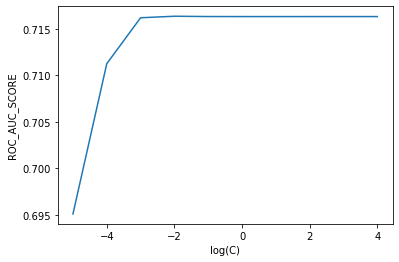

best_C = 0.01, best_score = 0.7163420915422014


In [15]:
tuning_C_parametr_for_LogisticRegression(X_train, y_train)

## Логистическая регрессия без категориальных признаков

****
**2.**Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [16]:
def remove_categorical_features(data, features_to_remove=[]):
    '''Удаляет выбранные признаки из данных'''
    
    return data.drop(columns=features_to_remove)

In [17]:
# Удаляем категориальные признаки
categorical_features = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
                                'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

X_train_remove_categorical = remove_categorical_features(X, categorical_features)

print(f'Формат обучающей выборки = {X_train_remove_categorical.shape}')
print(f'Вектор ответов имеет размерность = {y_train.shape}')

Формат обучающей выборки = (97230, 91)
Вектор ответов имеет размерность = (97230,)


In [18]:
# Нормализуем

X_train_remove_categorical = normalization_standart_scaler(X_train_remove_categorical)

In [19]:
# Кросс валидация

kf = KFold_cv(X_train_remove_categorical)

C =  1e-05
[0.69960017 0.69148876 0.69420354 0.69424161 0.69572094]
Accuracy: 0.69505 (+/- 0.01)
Time elapsed: 0:00:01.919835
**************************************************************
C =  0.0001
[0.71628682 0.70827317 0.70971968 0.71019908 0.71173161]
Accuracy: 0.71124 (+/- 0.01)
Time elapsed: 0:00:02.238337
**************************************************************
C =  0.001
[0.72152485 0.7136096  0.7144559  0.71521473 0.71636923]
Accuracy: 0.71623 (+/- 0.01)
Time elapsed: 0:00:04.153689
**************************************************************
C =  0.01
[0.72181625 0.71370029 0.71462426 0.71551483 0.71634683]
Accuracy: 0.71640 (+/- 0.01)
Time elapsed: 0:00:05.922428
**************************************************************
C =  0.1
[0.72181202 0.71363853 0.71460838 0.71550902 0.71630481]
Accuracy: 0.71637 (+/- 0.01)
Time elapsed: 0:00:05.859398
**************************************************************
C =  1.0
[0.72181077 0.71362888 0.7146083  0.71551056 0.7

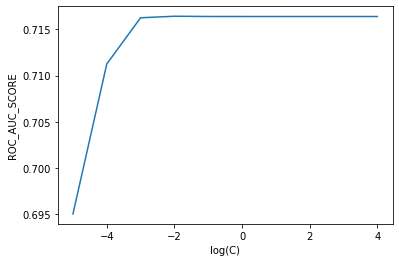

best_C = 0.01, best_score = 0.7164004932889204


In [20]:
# Подбираем параметр

tuning_C_parametr_for_LogisticRegression(X_train=X_train_remove_categorical, y_train=y_train)

## Логистическая регрессия с закодированной информацией о героях

***
**3.**Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

**4.**Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [21]:
heroes = pd.read_csv('/content/drive/My Drive/FinalProjectDota/heroes.csv')
print('Всего героев в игре: ', len(heroes))

Всего героев в игре:  112


In [22]:
def one_hot_encoding(initial_data, labels_data):
    '''Производит преобразование исходных категориальных данных при помощи подхода "мешок слов"'''
    
    initial_data = fillna_numeric(initial_data)
    
    X_pick = np.zeros((initial_data.shape[0], len(labels_data)))

    for i, match_id in enumerate(initial_data.index):
        for p in range(5):
            X_pick[i, initial_data.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, initial_data.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
    X_train_heroes_encoding = pd.DataFrame(X_pick, index=initial_data.index)
    print(f'Формат закодированных данных = {X_train_heroes_encoding.shape}')
    print(f'Формат исходных данных = {initial_data.shape}')
    
    return X_train_heroes_encoding

In [23]:
# Закодируем котегориальные признаки

X_train_heroes_encoding = one_hot_encoding(initial_data=X, labels_data=heroes)
X_train_heroes_encoding

Формат закодированных данных = (97230, 112)
Формат исходных данных = (97230, 102)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114403,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
114404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
# Объединяем датафреймы

X_train_heroes_encoding = pd.concat([X_train_remove_categorical, X_train_heroes_encoding], axis=1)
print(X_train_heroes_encoding.shape)

(97230, 203)


In [25]:
# Кросс валидация

kf = KFold_cv(X_train_heroes_encoding)

C =  1e-05
[0.70378174 0.69551484 0.69835678 0.69834211 0.6996389 ]
Accuracy: 0.69913 (+/- 0.01)
Time elapsed: 0:00:02.916340
**************************************************************
C =  0.0001
[0.73003005 0.72219731 0.72365637 0.72380729 0.7252633 ]
Accuracy: 0.72499 (+/- 0.01)
Time elapsed: 0:00:03.694086
**************************************************************
C =  0.001
[0.75072762 0.74413877 0.74561136 0.74433186 0.74666227]
Accuracy: 0.74629 (+/- 0.00)
Time elapsed: 0:00:07.909364
**************************************************************
C =  0.01
[0.75511791 0.74966666 0.75179155 0.74944243 0.75266193]
Accuracy: 0.75174 (+/- 0.00)
Time elapsed: 0:00:14.948306
**************************************************************
C =  0.1
[0.75515914 0.74990761 0.75213438 0.74956021 0.75292808]
Accuracy: 0.75194 (+/- 0.00)
Time elapsed: 0:00:22.898524
**************************************************************
C =  1.0
[0.75512408 0.74989821 0.75212827 0.74954032 0.7

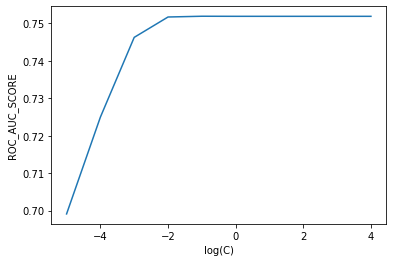

best_C = 0.1, best_score = 0.751937882223794


In [26]:
# Подбираем параметр

tuning_C_parametr_for_LogisticRegression(X_train=X_train_heroes_encoding, y_train=y_train, max_iter=200)

****

In [27]:
X_train_heroes_encoding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,1.507230,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,1.052453,1.115474,-0.417344,-0.322641,-0.337650,0.082842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.540452,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.591580,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,-0.573665,-1.352836,1.392776,1.286498,0.507465,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.539231,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-0.324070,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-0.277630,0.427498,1.202532,1.900308,-0.524078,-0.573665,0.292704,1.392776,1.901968,1.910183,0.860010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.532622,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,1.507230,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,-0.573665,-0.941451,1.392776,1.140213,0.050057,0.637962,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.529221,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,-1.243393,-1.008757,-1.213680,-1.167155,-0.533149,1.019572,-0.524101,-0.324070,-0.538623,-0.379666,-1.154419,1.014674,-0.578154,-0.112095,-0.282744,-0.424893,0.792515,0.674829,1.030097,-0.579877,1.122386,0.634915,0.584817,-0.445882,-0.334737,-0.524078,-0.573665,-0.118681,-0.417344,-0.954166,-1.230685,-1.138424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1.093978,0.501314,0.834109,0.107949,0.637942,-0.537757,1.017574,-0.108632,-1.243393,-1.032165,-1.250798,-1.167155,-0.533149,2.621540,0.708513,-0.324070,-0.547633,1.535778,1.303455,1.014674,1.039791,0.297720,0.632591,1.226845,0.594891,0.114162,1.030097,1.043031,0.298602,-0.277630,-1.002836,-1.136583,-1.005251,-0.524078,1.052453,-1.352836,-0.417344,-0.627700,-0.278841,-1.249448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114403,1.096181,0

## Другой подход замены признаков

In [28]:
def simple_imputer(data_train, data_test, strategy='mean'):
    
    from sklearn.impute import SimpleImputer
    import numpy as np 

    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(data_train)

    data_train_mean = imputer.transform(data_train)
    data_test_mean = imputer.transform(data_test)
    
    print('Формат обучающей выборки: ', data_train_mean.shape)
    print('Формат тестовой выборки: ', data_test_mean.shape)
    
    return pd.DataFrame(data_train_mean, index=data_train.index), pd.DataFrame(data_test_mean, index=data_test.index, columns=data_test.columns)

In [29]:
features_1.drop(columns=['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 
                       'barracks_status_radiant', 'barracks_status_dire'], inplace=True)

In [30]:
X_train_si, x_test_si = simple_imputer(features_1, test_1, strategy='median')

Формат обучающей выборки:  (97230, 102)
Формат тестовой выборки:  (17177, 102)


In [31]:
X_train_si

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.430199e+09,7.0,11.0,5.0,2098.0,1489.0,20.0,0.0,0.0,7.0,67.0,3.0,842.0,991.0,10.0,0.0,0.0,4.0,29.0,5.0,1909.0,1143.0,10.0,0.0,0.0,8.0,20.0,3.0,757.0,741.0,6.0,0.0,0.0,7.0,105.0,3.0,732.0,658.0,4.0,0.0,...,23.0,0.0,0.0,6.0,37.0,3.0,742.0,500.0,2.0,0.0,0.0,8.0,84.0,3.0,958.0,1003.0,3.0,1.0,0.0,9.0,7.0,1.0,9.0,4.0,134.0,-80.0,244.0,2.0,2.0,2.0,0.0,35.0,103.0,-84.0,221.0,3.0,4.0,2.0,2.0,-52.0
1,1.430220e+09,0.0,42.0,4.0,1188.0,1033.0,9.0,0.0,1.0,12.0,49.0,4.0,1596.0,993.0,10.0,0.0,1.0,7.0,67.0,4.0,1506.0,1502.0,18.0,1.0,0.0,7.0,37.0,3.0,669.0,631.0,7.0,0.0,0.0,7.0,26.0,2.0,415.0,539.0,1.0,0.0,...,2.0,2.0,0.0,12.0,7.0,2.0,440.0,583.0,0.0,0.0,0.0,7.0,12.0,4.0,1470.0,1622.0,24.0,0.0,0.0,9.0,54.0,1.0,7.0,4.0,173.0,-80.0,204.0,2.0,0.0,2.0,0.0,-20.0,149.0,-84.0,195.0,5.0,4.0,3.0,1.0,-5.0
2,1.430227e+09,7.0,33.0,4.0,1319.0,1270.0,22.0,0.0,0.0,12.0,98.0,3.0,1314.0,775.0,6.0,0.0,0.0,6.0,20.0,3.0,1297.0,909.0,0.0,1.0,0.0,6.0,27.0,5.0,2360.0,2096.0,26.0,1.0,1.0,6.0,4.0,3.0,1395.0,1627.0,27.0,0.0,...,3.0,0.0,0.0,8.0,29.0,4.0,1319.0,667.0,4.0,0.0,0.0,7.0,80.0,3.0,1350.0,1512.0,25.0,0.0,0.0,7.0,224.0,0.0,3.0,4.0,63.0,-82.0,204.0,2.0,5.0,2.0,1.0,-39.0,45.0,-77.0,221.0,3.0,4.0,3.0,1.0,13.0
3,1.430264e+09,1.0,29.0,4.0,1779.0,1056.0,14.0,0.0,0.0,5.0,30.0,2.0,539.0,539.0,1.0,0.0,0.0,6.0,75.0,5.0,2037.0,1139.0,15.0,0.0,0.0,6.0,37.0,2.0,591.0,499.0,0.0,0.0,0.0,6.0,41.0,3.0,712.0,1075.0,12.0,0.0,...,11.0,0.0,0.0,7.0,102.0,2.0,674.0,537.0,1.0,0.0,0.0,7.0,20.0,2.0,510.0,499.0,0.0,0.0,0.0,7.0,93.0,1.0,5.0,4.0,208.0,-75.0,204.0,0.0,3.0,2.0,0.0,-30.0,124.0,-80.0,184.0,0.0,4.0,2.0,0.0,27.0
4,1.430282e+09,7.0,13.0,4.0,1431.0,1090.0,8.0,1.0,0.0,8.0,27.0,2.0,629.0,552.0,0.0,0.0,1.0,7.0,30.0,3.0,884.0,927.0,0.0,1.0,0.0,8.0,72.0,3.0,925.0,1439.0,16.0,1.0,0.0,11.0,93.0,4.0,1482.0,880.0,7.0,0.0,...,1.0,0.0,0.0,9.0,25.0,5.0,1815.0,1275.0,18.0,0.0,0.0,8.0,8.0,4.0,1119.0,904.0,6.0,0.0,1.0,7.0,-21.0,1.0,6.0,4.0,166.0,-81.0,181.0,1.0,4.0,2.0,0.0,46.0,182.0,-80.0,225.0,6.0,3.0,3.0,0.0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1.450266e+09,1.0,47.0,4.0,1706.0,1198.0,17.0,0.0,1.0,8.0,7.0,2.0,616.0,535.0,0.0,0.0,2.0,10.0,1.0,3.0,879.0,1798.0,22.0,1.0,1.0,9.0,21.0,4.0,1835.0,1350.0,11.0,1.0,1.0,9.0,71.0,3.0,604.0,567.0,1.0,0.0,...,18.0,0.0,1.0,9.0,3.0,3.0,972.0,847.0,1.0,1.0,1.0,11.0,28.0,3.0,1583.0,1634.0,10.0,2.0,0.0,6.0,114.0,0.0,2.0,8.0,245.0,-86.0,211.0,5.0,2.0,1.0,0.0,-29.0,180.0,-76.0,180.0,3.0,4.0,3.0,0.0,-24.0
114403,1.450278e+09,0.0,43.0,4.0,1793.0,1416.0,17.0,0.0,1.0,5.0,26.0,3.0,764.0,800.0,0.0,1.0,0.0,9.0,4.0,3.0,1130.0,1585.0,20.0,1.0,1.0,14.0,29.0,4.0,1546.0,1166.0,8.0,1.0,0.0,6.0,110.0,3.0,892.0,541.0,1.0,0.0,...,1.0,0.0,1.0,6.0,20.0,4.0,1260.0,1008.0,4.0,1.0,1.0,12.0,98.0,5.0,1791.0,1186.0,3.0,1.0,0.0,8.0,174.0,1.0,9.0,4.0,139.0,-85.0,202.0,5.0,3.0,2.0,0.0,-5.0,131.0,-82.0,203.0,4.0,3.0,2.0,0.0,-17.0
114404,1.450292e+09,1.0,98.0,4.0,1399.0,540.0,1.0,0.0,0.0,5.0,11.0,4.0,1448.0,1371.0,17.0,0.0,1.0,13.0,112.0,3.0,658.0,646.0,2.0,0.0,0.0,10.0,81.0,4.0,1710.0,1833.0,24.0,1.0,0.0,10.0,50.0,2.0,364.0,674.0,1.0,0.0,...,16.0,1.0,0.0,8.0,59.0,4.0,1778.0,1614.0,27.0,0.0,0.0,8.0,31.0,3.0,841.0,499.0,1.0,0.0,0.0,10.0,108.0,0.0,3.0,5.0,43.0,-83.0,181.0,2.0,4.0,4.0,2.0,-32.0,249.0,-70.0,203.0,1.0,1.0,3.0,1.0,-15.0


In [32]:
# Нормализуем

X_train_si = normalization_standart_scaler(X_train_si)

In [33]:
# Кодируем признаки

X_train_si_heroes_encoding = one_hot_encoding(initial_data=X, labels_data=heroes)

# Объединяем датафреймы

X_train_si = pd.concat([X_train_si, X_train_si_heroes_encoding], axis=1)

# Кросс валидация

#kf = KFold_cv(X_train_si)

# Подбираем параметр

#tuning_C_parametr_for_LogisticRegression(X_train=X_train_si, y_train=y_train, max_iter=200)

Формат закодированных данных = (97230, 112)
Формат исходных данных = (97230, 102)


Качество слегка улучшилось

## Тестовая выборка

In [34]:
model = LogisticRegression(C=0.1, random_state=241, max_iter=200)
model.fit(X_train_si, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=241, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
x_test_si = test_1

# Заполняем пропущенные значения
X_train_si, x_test_si = simple_imputer(features_1, test_1, strategy='median')

# Нормализуем

x_test_si_rc_norm = normalization_standart_scaler(x_test_si)

# Кодируем признаки

x_test_si_heroes_encoding = one_hot_encoding(initial_data=test_1, labels_data=heroes)

# Объединяем датафреймы

x_test_si = pd.concat([x_test_si_rc_norm, x_test_si_heroes_encoding], axis=1)


Формат обучающей выборки:  (97230, 102)
Формат тестовой выборки:  (17177, 102)
Формат закодированных данных = (17177, 112)
Формат исходных данных = (17177, 102)


In [37]:
predictions = model.predict_proba(x_test_si)

In [39]:
predictions

array([[0.15180783, 0.84819217],
       [0.25361879, 0.74638121],
       [0.789251  , 0.210749  ],
       ...,
       [0.76317717, 0.23682283],
       [0.40454933, 0.59545067],
       [0.56676426, 0.43323574]])

In [40]:
# Оформим в csv файл 
radiant_win = np.squeeze(predictions[:,1:])
result = {'match_id' : x_test_si.index.values, 'radiant_win' : radiant_win}
result_predictions = pd.DataFrame(result)
result_predictions.set_index('match_id')
result_predictions.to_csv('radiant_win.csv',encoding='utf-8',index=False)

## Отчет

**1. Какое качество получилось у логистической регрессии над всеми исходными  признаками? Как оно соотносится с качеством градиентного бустинга? Чем  можно объяснить эту разницу? Быстрее ли работает логистическая регрессия  по сравнению с градиентным бустингом?** 

* Качество логистической регрессии над всеми исходными признаками получилось: **best_C = 0.01, best_score = 0.716**
* Оно существенно больше чем у градиентного бустинга 
* Логистическая регрессия обучилась гораздо быстрее

**2. Как влияет на качество логистической регрессии удаление категориальных  признаков (укажите новое значение метрики качества)? Чем можно объяснить  это изменение?**
* Удаление категориальных признаков почти не влияет на качество регрессии: **best_C = 0.01, best_score = 0.716**
* Это означает, что вес этого параметра в предыдущей модели близок к нулю

**3. Сколько различных идентификаторов героев существует в данной игре?**
* 112

**4. Какое получилось качество при добавлении "мешка слов" по героям?  Улучшилось ли оно по сравнению с предыдущим вариантом? Чем можно это  объяснить?**

* После добавления "мешка слов" качество заметно улучшилось: **best_C = 0.1,    best_score = 0.751**
* Закодировав таким образом категориальные переменные мы получили разреженную матрицу, которая дает удобоваримую для модели информацию о том, какие герои учавствовали в игре. Эти данные уже можно использовать для улучшения предсказания, что и привело к повышению качества.

**5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?**

* Лучшим алгоритмом из испробованных была логистическая регрессия
* **Минимальное** значение прогноза получилось при обучении на всех исходных признаках. Оно равно **0.716**
* **Максимальное** значение было достигнуто после удаления и кодирования категориальных признаков. Оно равно **0.751**